In [ ]:
pip install einops timm flash_attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.10

In [ ]:
import os
import json
from PIL import Image , UnidentifiedImageError
from sklearn.model_selection import train_test_split
from transformers import AutoProcessor, AutoModelForCausalLM
import torch
from collections import defaultdict
from google.colab import drive
import random

In [ ]:
def load_image_files(path):
    return [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]


In [ ]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)



config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def get_annotations(image_path, task_prompt):

    try:
        image = Image.open(image_path)
    except UnidentifiedImageError:
        print(f"Error: Cannot identify image file {image_path}")
        return {'<OD>': {'labels': [], 'bboxes': []}}

    inputs = processor(text=task_prompt, images=image, return_tensors="pt")
    inputs["input_ids"] = inputs["input_ids"].to('cuda', dtype=torch.long)
    inputs["pixel_values"] = inputs["pixel_values"].to('cuda', dtype=torch.float16)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )
    return parsed_answer

In [ ]:
import os
import random
from collections import defaultdict

def create_filtered_dataset(dataset_path, image_file_names, num_images_per_class_train=500, num_images_per_class_val=100, shuffle=False):
    if shuffle:
        random.shuffle(image_file_names)

    train_images = []
    val_images = []
    train_counts = defaultdict(int)
    val_counts = defaultdict(int)


    for img_file in image_file_names:
        img_path = os.path.join(dataset_path, img_file)
        annotations = get_annotations(img_path, '<OD>')
        labels = [label.lower() for label in annotations.get('<OD>', {}).get('labels', [])]
        bboxes = annotations.get('<OD>', {}).get('bboxes', [])

        found_labels = get_labels(labels, bboxes)

        # Track which classes are found in the image
        classes_found = set()
        for label, bbox in found_labels:
            classes_found.add(label)

        # Add the image to the appropriate set based on label and counts
        for label in classes_found:
            if label == 'person':
                if train_counts['person'] < num_images_per_class_train:
                    train_images.append((img_file, 'person', [bbox for l, bbox in found_labels if l == 'person']))
                    train_counts['person'] += 1
                    print(f"{img_file} added to train (person - {train_counts['person']})")
                elif val_counts['person'] < num_images_per_class_val:
                    val_images.append((img_file, 'person', [bbox for l, bbox in found_labels if l == 'person']))
                    val_counts['person'] += 1
                    print(f"{img_file} added to validation (person - {val_counts['person']})")
            elif label == 'pet':
                if train_counts['pet'] < num_images_per_class_train:
                    train_images.append((img_file, 'pet', [bbox for l, bbox in found_labels if l == 'pet']))
                    train_counts['pet'] += 1
                    print(f"{img_file} added to train (pet - {train_counts['pet']})")
                elif val_counts['pet'] < num_images_per_class_val:
                    val_images.append((img_file, 'pet', [bbox for l, bbox in found_labels if l == 'pet']))
                    val_counts['pet'] += 1
                    print(f"{img_file} added to validation (pet - {val_counts['pet']})")

        if (train_counts['pet'] >= num_images_per_class_train and
            train_counts['person'] >= num_images_per_class_train and
            val_counts['pet'] >= num_images_per_class_val and
            val_counts['person'] >= num_images_per_class_val):
            break

    return train_images, val_images

def get_labels(labels, bboxes):
    pet_label = 'pet'
    person_label = 'person'
    animal_labels = ['cat', 'dog', 'cats', 'dogs', 'kitty', 'kitten', 'puppy']
    people_labels = ['man', 'woman', 'person', 'human face', 'boy', 'girl', 'baby', 'child', 'people', 'children', 'male', 'female', 'toddler', 'kid', 'newborn']

    found_labels = []
    for label, bbox in zip(labels, bboxes):
        if label in people_labels:
            found_labels.append((person_label, bbox))
        elif label in animal_labels:
            found_labels.append((pet_label, bbox))
    return found_labels

In [ ]:
def save_paths_to_json(data, output_path):
    with open(output_path, 'w') as f:
        json.dump(data, f)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
def main():
    # Define paths and parameters
    dataset_path = '/content/drive/MyDrive/flickr30k_images/flickr30k_images'  # Path where your images are stored in Google Drive
    image_file_names = os.listdir(dataset_path)
    num_images_per_class_train = 500
    num_images_per_class_validation = 100
    shuffle_images = True

    # Prepare dataset
    train_images, val_images = create_filtered_dataset(
        dataset_path, image_file_names,
        num_images_per_class_train, num_images_per_class_validation,
        shuffle_images
    )


    print("Training set size:", len(train_images))
    print("Validation set size:", len(val_images))

    # Save paths to JSON files
    train_output_path = '/content/drive/MyDrive/annotations3_train.json'
    val_output_path = '/content/drive/MyDrive/annotations3_val.json'
    save_paths_to_json(train_images, train_output_path)
    save_paths_to_json(val_images, val_output_path)

    print(f"Training paths saved to {train_output_path}")
    print(f"Validation paths saved to {val_output_path}")

if __name__ == "__main__":
    main()

288776839.jpg added to train (person - 1)
2452794213.jpg added to train (person - 2)
145645390.jpg added to train (person - 3)
4232844448.jpg added to train (person - 4)
3613667665.jpg added to train (person - 5)
3613667665.jpg added to train (pet - 1)
2865725777.jpg added to train (person - 6)
3486869248.jpg added to train (person - 7)
2809793070.jpg added to train (pet - 2)
358718746.jpg added to train (person - 8)
19023618.jpg added to train (person - 9)
3856990752.jpg added to train (person - 10)
346698309.jpg added to train (person - 11)
2194494220.jpg added to train (person - 12)
2194494220.jpg added to train (pet - 3)
3451344589.jpg added to train (person - 13)
3687995245.jpg added to train (person - 14)
2841196844.jpg added to train (person - 15)
2992226950.jpg added to train (person - 16)
3451085951.jpg added to train (pet - 4)
1174629344.jpg added to train (person - 17)
315574711.jpg added to train (person - 18)
3072172967.jpg added to train (person - 19)
2103568100.jpg added

In [16]:
image = Image.open('/content/drive/MyDrive/flickr30k_images/flickr30k_images/233581449.jpg')


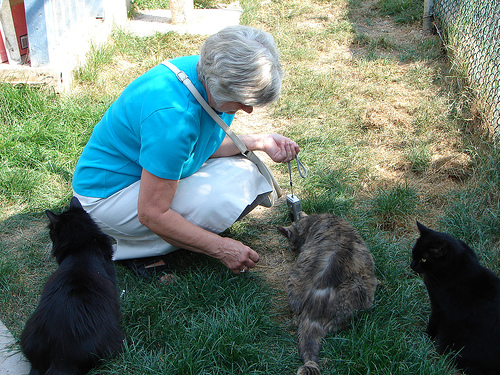

In [17]:
display(image)